# Compare offline turbulence to observations
### Bias between observed and offline simulated turbulence

In [1]:
# -------------------------------------------------------------------------------------------------------
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# -------------------------------------------------------------------------------------------------------
# OS interaction
import sys, pickle, os

# -------------------------------------------------------------------------------------------------------
# plotting packages
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
from string import ascii_lowercase

# -------------------------------------------------------------------------------------------------------
# Custom packages
import kgraph
import turbpy
import turbpy.multiConst as mc


# -------------------------------------------------------------------------------------------------------
# Customize
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context('paper')
import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

# -------------------------------------------------------------------------------------------------------
# Directories
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dirProj = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/'
dirPrint = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'
dirDataSCP = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SCP'
dirDataSNQ = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ'

### Surface observations

In [2]:
# -------------------------------------------------------------------------------------------------------
# SNQ
os.chdir(dirDataSNQ)
SNQ = xr.open_dataset('SnoqualmieObs.SupportData.wy2013_wy2015.nc')

# Indices of simulated turbulence times (observations exist, wind > 2m/s, snow is present)
SNQind = np.nonzero((SNQ.SP == 1).values &
                    (SNQ.WIND > 2).values &
                    (~(np.isnan(SNQ.SensFlux)).values |
                    ~(np.isnan(SNQ.LatFlux)).values))

# -------------------------------------------------------------------------------------------------------
# SCP
os.chdir(dirDataSCP)
radObs = xr.open_dataset('SCP.rad_obs.netcdf')
SCP = xr.open_dataset('SCP.Mtower.netcdf')
fluxObs = xr.open_dataset('SCP.flux_obs.netcdf')

# Turbulence
SCP['w_tc__2m'] = fluxObs.w_tc__2m_M
SCP['w_tc_10m'] = fluxObs.w_tc__10m_M

# Surface temperature from upwelling longwave
sigma = 5.67*10**-8.
Tsfc = (radObs.Rlw_out / sigma) ** (1 / 4)
SCP['Tsfc'] = (('time'), Tsfc - 273.15)

# Wind speed magnitude
SCP['UBar_15m'] = (('time'), (SCP.U_15m_M**2 + SCP.V_15m_M**2) ** (1 / 2))
SCP.UBar_15m[SCP.UBar_15m > 10] = np.nan
SCP['UBar_2m'] = (('time'), (SCP.u_2m_M**2 + SCP.v_2m_M**2) ** (1 / 2))
SCP.UBar_15m[SCP.UBar_2m > 10] = np.nan

# Bulk Richardson number
RiBulk_15m,_,_ = turbpy.bulkRichardson(SCP.T_15m_M + 273.15, SCP.Tsfc + 273.15, SCP.UBar_15m, 15.)
SCP['RiBulk_15m'] = RiBulk_15m
RiBulk_2m,_,_ = turbpy.bulkRichardson(SCP.T_1m_M + 273.15, SCP.Tsfc + 273.15, SCP.UBar_2m, 2.)
SCP['RiBulk_2m'] = RiBulk_2m

# Indices of stable periods (simulated)
SCPind = np.nonzero((SCP.RiBulk_15m > 0.).values)

## Offline Turbulence results

#### SCP
- Run in the script TF.SUMMATurbConversion_SCP.py script on j-lundquist-3
- Results saved to OfflineTurb.SCP.sensible_1m.ALL.nc. The "ALL" refers to doing offline simulations on all stable conditions, instead of just a 5% sample, as in previous iterations.
- The criteria for stable conditions comes from the 15m observations

#### SNQ
- Simulation run in TF.OfflineTurb.SNQ
- the resulting netcdf was copied from the SNQ data directory to the project level directory. Re-running the script won't change the results in this script unless explicitly moved again.
- Simulations only run for periods of wind > 2m/s

In [3]:
os.chdir(dirProj)
ixStability = ('standard','louisInversePower','mahrtExponential','moninObukhov')

# -------------------------------------------------------------------------------------------------------
# SNQ Offline Turbulence results
SNQ_sensible = xr.open_dataset('TF.SNQ_wind2msSP.OfflineTurb.sensible.nc')
SNQ_latent = xr.open_dataset('TF.SNQ_wind2msSP.OfflineTurb.latent.nc')

# -------------------------------------------------------------------------------------------------------
# SCP Offline Turbulence results
SCP_sensible_1m = xr.open_dataset('OfflineTurb.SCP.sensible_1m.ALL.nc')
SCP_sensible_15m = xr.open_dataset('OfflineTurb.SCP.sensible_15m.ALL.nc')
SCP_latent_1m = xr.open_dataset('OfflineTurb.SCP.latent_1m.ALL.nc')
SCP_latent_15m = xr.open_dataset('OfflineTurb.SCP.latent_15m.ALL.nc')

### Compare offline turb to observed turb

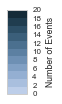

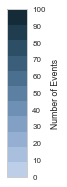

In [16]:
## General colorbar arguments
cmin = 0
cmax = 100
ncol = 11
dcol = (cmax - cmin) / (ncol - 1)
cmap = sns.cubehelix_palette(11, start=2.6, rot=.075, light=0.8, as_cmap=True)
cmap = kgraph.cmap_discretize(cmap, ncol)

# Colorbar for Snoqualmie
fig, caxi = plt.subplots(1, 1, figsize=(.35, 1.5))
# Set the colormap and norm to correspond to the data for which
# the colorbar will be used.
norm = matplotlib.colors.Normalize(vmin=0, vmax=20)
cbar = matplotlib.colorbar.ColorbarBase(caxi, cmap=cmap, norm=norm, orientation='vertical')

# cbar = plt.colorbar(im, cax=caxi, orientation="vertical", spacing='proportional')
cbar.ax.set_ylabel('Number of Events')
fig.savefig('OfflineTurb.2dHist.Colorbar.SNQ.pdf', bbox_inches='tight')

# Colorbar for the Shallow Cold Pool
fig, caxi = plt.subplots(1, 1, figsize=(.35, 3))
# Set the colormap and norm to correspond to the data for which
# the colorbar will be used.
norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
cbar = matplotlib.colorbar.ColorbarBase(caxi, cmap=cmap,
                                norm=norm,
                                orientation='vertical')

# cbar = plt.colorbar(im, cax=caxi, orientation="vertical", spacing='proportional')
cbar.ax.set_ylabel('Number of Events')
fig.savefig('OfflineTurb.2dHist.Colorbar.SCP.pdf', bbox_inches='tight')

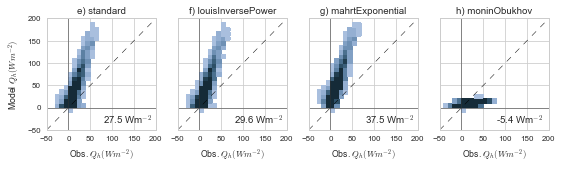

In [17]:
os.chdir(dirPrint)

# -------------------------------------------------------------------------------------------------------
# SCP - 2m
ymin = -50
ymax = 200
dx = 10
xmin = ymin
xmax = ymax
dy = dx

# Format figure
fig, axes = plt.subplots(1, 4, figsize=(9, 2), sharex='col', sharey='row')
axes = axes.flatten()

# Simulated turbulence
for ix, stab in enumerate(ixStability):
    ax = axes[ix]
    
    # Build my own histogram
    X = -SCP.w_tc__2m[SCPind].values.flatten()
    Y = SCP_sensible_1m[stab].values.flatten()  
    H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax, dx),
                                                   np.arange(ymin, ymax, dy)))
    H = np.ma.masked_array(H, H < cmin+dcol)

    # Plot my 2D histogram
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
    
    # Zero lines
    ax.plot([xmin, xmax], [ymin, ymax], 'k--', linewidth=.5)
    ax.plot([0, 0], [ymin, ymax], linewidth=0.5, color='.2')
    ax.plot([xmin, xmax], [0, 0], linewidth=0.5, color='.2')

    # Format
    ax.set_title(ascii_lowercase[ix + 4] + ") " + stab)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('Obs. $Q_h (Wm^{-2})$')
    ax.grid()

    # Bias
    bias = np.nanmean(SCP_sensible_1m[stab] + SCP.w_tc__2m[SCPind])
    ax.text(80, -35, '%2.1f' % bias + ' Wm$^{-2}$')
axes[0].set_ylabel('Model $Q_h (Wm^{-2})$')
fig.savefig('OfflineTurb.SCP_2m.2dHist_Bias.pdf', bbox_inches='tight')

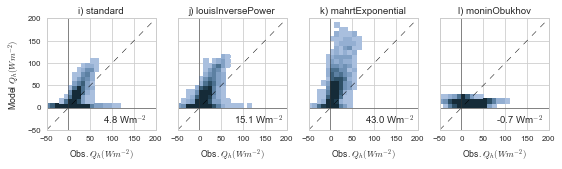

In [18]:
os.chdir(dirPrint)

# -------------------------------------------------------------------------------------------------------
# SCP - 2m
ymin = -50
ymax = 200
dx = 10
xmin = ymin
xmax = ymax
dy = dx

# Format figure
fig, axes = plt.subplots(1, 4, figsize=(9, 2), sharex='col', sharey='row')
axes = axes.flatten()

# Simulated turbulence
for ix, stab in enumerate(ixStability):
    ax = axes[ix]
    
    # Build my own histogram
    X = -SCP.w_tc_10m[SCPind].values.flatten()
    Y = SCP_sensible_15m[stab].values.flatten()  
    H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax, dx),
                                                   np.arange(ymin, ymax, dy)))
    H = np.ma.masked_array(H, H < cmin+dcol)

    # Plot my 2D histogram
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
    
    # Zero lines
    ax.plot([xmin, xmax], [ymin, ymax], 'k--', linewidth=.5)
    ax.plot([0, 0], [ymin, ymax], linewidth=0.5, color='.2')
    ax.plot([xmin, xmax], [0, 0], linewidth=0.5, color='.2')

    # Format
    ax.set_title(ascii_lowercase[ix + 8] + ") " + stab)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('Obs. $Q_h (Wm^{-2})$')
    ax.grid()

    # Bias
    bias = np.nanmean(SCP_sensible_15m[stab] + SCP.w_tc_10m[SCPind])
    ax.text(80, -35, '%2.1f' % bias + ' Wm$^{-2}$')
axes[0].set_ylabel('Model $Q_h (Wm^{-2})$')
fig.savefig('OfflineTurb.SCP_15m.2dHist_Bias.pdf', bbox_inches='tight')


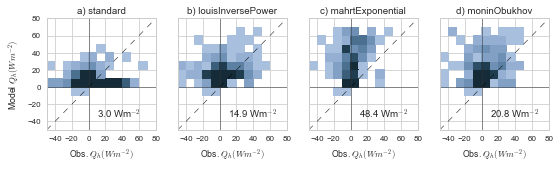

In [19]:
os.chdir(dirPrint)

# -------------------------------------------------------------------------------------------------------
# SNQ
ymin = -50
ymax = 80
dy = 10
xmin = ymin
xmax = ymax
dx = dy

cmin = 0
cmax = 20
ncol = 11
dcol = (cmax - cmin) / (ncol - 1)

# Format figure
fig, axes = plt.subplots(1, 4, figsize=(9, 2), sharex='col', sharey='row')
axes = axes.flatten()

# Simulated turbulence
for ix, stab in enumerate(ixStability):
    ax = axes[ix]
    
    # Build my own histogram
    X = SNQ.SensFlux[SNQind].values.flatten()
    Y = SNQ_sensible[stab].values.flatten()  
    H, xedges, yedges = np.histogram2d(X, Y, bins=(np.arange(xmin, xmax, dx),
                                                   np.arange(ymin, ymax, dy)))
    H = np.ma.masked_array(H, H < cmin+dcol)
    
    # Plot my 2D histogram
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax, linewidth=0, rasterized=True)
    
    # One to one line
    ax.plot([xmin, xmax], [ymin, ymax], 'k--', linewidth=.5)

    # zero lines
    ax.plot([0, 0], [ymin, ymax], linewidth=0.5, color='.2')
    ax.plot([xmin, xmax], [0, 0], linewidth=0.5, color='.2')
    
    # Formatting
    ax.set_title(ascii_lowercase[ix] + ") " + stab)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('Obs. $Q_h (Wm^{-2})$')
    ax.grid()
    
    bias = np.nanmean(SNQ_sensible[stab] - SNQ.SensFlux[SNQind])
    ax.text(10, -35, '%2.1f' % bias + ' Wm$^{-2}$')
axes[0].set_ylabel('Model $Q_h (Wm^{-2})$')
fig.savefig('OfflineTurb.SNQ.2dHist_Bias.pdf', bbox_inches='tight')


How many stable events per site?

In [41]:
print(np.size(SCPind))
print(np.size(SNQind))

12045
565


In [ ]:
print(SCP_sensible_15m.mean(dim='time'))
print(SCP_sensible_1m.mean(dim='time'))
print(SNQ_sensible.mean(dim='time'))

In [ ]:
print(SNQ.SensFlux[SNQind].mean(dim='time'))
print(-SCP.w_tc_10m[SCPind].mean(dim='time'))
print(-SCP.w_tc__2m[SCPind].mean(dim='time'))